In [3]:
import numpy as np 
import torch 
import garch_framework as frame
from garch_framework.layers.losses import CorrectedNLoss
from garch_framework.utils.helpers import generate_ground_data, save_model_params
from garch_framework.utils.datasets import LSTMGARCHDataset
from garch_framework.models import GARCHLSTM, GJRGARCHModel
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from arch import arch_model
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [4]:
data = pd.read_csv('real_dataset/DJI_10years.csv')

In [5]:
prices = data.iloc[:,1].values

In [6]:
prices_diff = np.diff(np.log(prices))

In [7]:
prices_diff.shape

(2514,)

In [8]:
prices_diff = (prices_diff - np.mean(prices_diff))

In [9]:
window_size = 5
volatilities = []

for i in range(len(prices_diff) - window_size):
    window = prices_diff[i : i + window_size]
    volatility = np.sqrt(np.sum(window**2))  
    volatilities.append(volatility)

volatilities = np.array(volatilities)

In [10]:
prices_diff = prices_diff[window_size:]

In [11]:
volatilities = np.square(volatilities)

In [12]:
volatilities.shape

(2509,)

In [13]:
prices_diff.shape

(2509,)

In [14]:
volatilities = volatilities 
prices_diff = prices_diff 

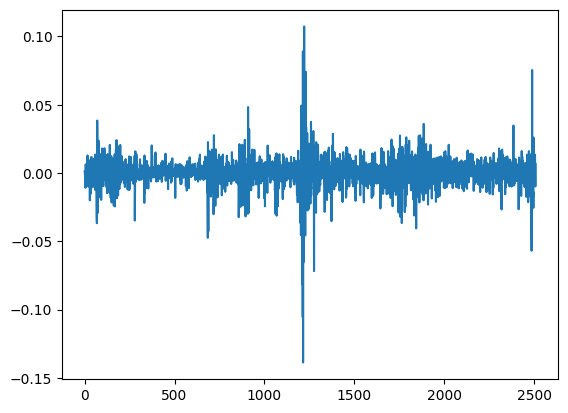

In [15]:
plt.plot(prices_diff)

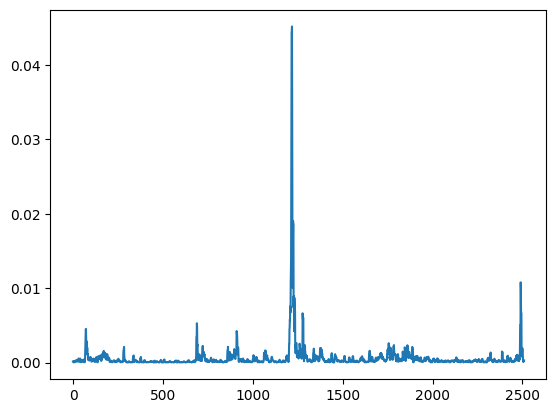

In [16]:
plt.plot(volatilities)

In [ ]:
class GarchDataset(Dataset):
    def __init__(self, residuals, volatility, scale=1, oth_scale = 1):
        self.scale = scale
        self.oth_scale = oth_scale

        self.residuals = torch.tensor(residuals, dtype=torch.float32)
        self.volatility = torch.tensor(volatility, dtype=torch.float32)

        self.residuals_scaled = torch.square(self.residuals) * self.scale
        self.volatility_scaled = torch.square(self.volatility) * self.scale 
        

        self.inputs = torch.column_stack([
            torch.ones_like(self.residuals_scaled)*self.oth_scale,   # 
            self.residuals_scaled,
            self.volatility_scaled
        ])
        


    def __len__(self):
        return len(self.inputs)-1 
    

    def __getitem__(self, index):
        return (
            self.inputs[index],
            self.residuals_scaled[index+1]
        )